# Statistical Analysis of groups

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import logging
logging.basicConfig(
    level= logging.INFO,
    format= "%(asctime)s - %(levelname)s - %(message)s"
)

## Data Loading and Manipulation

In [2]:
p1: pd.DataFrame = pd.read_parquet(path="../data/p1.parquet")
p2: pd.DataFrame = pd.read_parquet(path="../data/p2.parquet")
logging.info("Loaded parquets into Dataframes")

2025-11-20 12:34:47,315 - INFO - Loaded parquets into Dataframes


In [3]:
p1 = p1.drop(columns=["month"])
p2 = p2.drop(columns=["month"])

Creating merged DataFrame

In [4]:
p1["group"] = 1
p2["group"] = 2

p: pd.DataFrame = pd.concat([p1, p2])
p1 = p1["total_hours"]
p2 = p2["total_hours"]

## Visual Exploration

### Box plot

2025-11-20 12:34:47,527 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 12:34:47,553 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


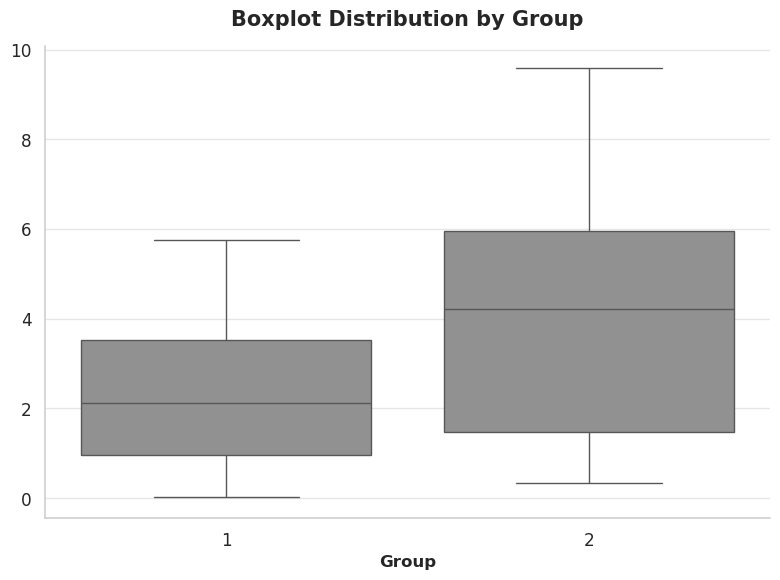

In [5]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})


plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    x="group",
    y = "total_hours",
    data = p,
    color="#919191F1", 
)

ax.set_xlabel("Group", fontsize=12, weight='bold')
ax.set_ylabel("", fontsize=12, weight='bold')
ax.set_title("Boxplot Distribution by Group", fontsize=15, weight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/boxplot_by_group.png", dpi=300, bbox_inches="tight")
plt.show()

## Shapiro Wilk Test

In [6]:
def normality_test(x: pd.Series, name: str) -> None:
    stat, p = stats.shapiro(x)
    print(f'{name}: W={stat:.3f}, p={p:.3f}', 'Normal' if p > 0.05 else 'NOT normal')

normality_test(p1, "Group 1")
normality_test(p2, "Group 2")

Group 1: W=0.951, p=0.005 NOT normal
Group 2: W=0.934, p=0.000 NOT normal


## Levene Test

In [7]:
stat, p = stats.levene(p1, p2)
print(f'Levene: stat={stat:.3f}, p={p:.3f}', 'Equal variances' if p > 0.05 else 'Different variances')

Levene: stat=29.672, p=0.000 Different variances


## Mann-Whitney U test

Since the data is not normaly distributed this test is chosen

In [8]:
u_stat, p_val = stats.mannwhitneyu(p1, p2, alternative='two-sided')
print(f'Mann-Whitney U test: U={u_stat:.3f}, p={p_val:.3f}')

Mann-Whitney U test: U=3246.000, p=0.000


## Effect Size: r from Mann-Whitney U

In [9]:
def mannwhitneyu_effect_size(n1:int , n2: int, u_stat):
    mu_U = n1 * n2 / 2
    sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z_stat = (u_stat - mu_U) / sigma_U
    N = n1 + n2
    r = z_stat / np.sqrt(N)

    return r

r = mannwhitneyu_effect_size(len(p1), len(p2), u_stat)
print(f'Mann-Whitney U effect size (r) = {r:.3f}', 
      'small' if abs(r) < 0.1 else 'medium' if abs(r) < 0.3 else 'large')

Mann-Whitney U effect size (r) = -0.350 large


## Summary

In [10]:
summary = pd.DataFrame({
    'Group': ['A', 'B'],
    'N': [len(p1), len(p2)],
    'Median': [p1.median(), p2.median()],
    'IQR': [p1.quantile(0.75) - p1.quantile(0.25), p2.quantile(0.75) - p2.quantile(0.25)]
})
summary

,Group,N,Median,IQR
0,A,77,2.114898,2.559208
1,B,147,4.211173,4.480376


## Interpretation

The normality tests for both groups show p-values smaller than 0.005, indicating that they are significantly different from a normal distribution.

The Levene test indicates that the variances of the two groups are significantly different, suggesting that the assumption of equal variances is violated.

The Mann-Whitney U test shows a statistically significant difference between the two groups, meaning that the observed difference is unlikely to be due to random chance.

The effect size analysis is classified as large. The negative sign indicates that the median of Group 1 (p1) is lower than the median of Group 2 (p2), suggesting a substantial difference between the two groups.

Given all these results, it suggests that there is a notable difference between Group 1 (p1) and Group 2 (p2), and this difference is statistically significant